In [39]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import PIL


In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Pre Process

In [53]:
data_dir = "archive\Garbage classification\Garbage classification"
img_height = 180
img_width = 180   

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\jiray\AppData\Local\Temp\ipykernel_42276\2288252158.py:1: SyntaxWarning: invalid escape sequence '\G'
  data_dir = "archive\Garbage classification\Garbage classification"


In [77]:
class_count = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_files = len(os.listdir(class_path))
    class_count[class_name] = num_files
    print(f"{class_name} {num_files}")

max_class = max(class_count.values())
print(class_count)
print(f"Max class = {max_class}")

cardboard 403
glass 501
metal 410
paper 594
plastic 482
trash 137
{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}
Max class = 594


Data Augmentation

In [91]:
class ProbabilisticLayer(tf.keras.layers.Layer):
    def __init__(self, layer, probability=0.5, **kwargs):
        super(ProbabilisticLayer, self).__init__(**kwargs)
        self.layer = layer
        self.probability = probability

    def call(self, inputs, training=None):
        # ถ้าไม่ได้อยู่ในโหมด training ให้ข้ามไปเลย
        if not training:
            return inputs
        
        # สุ่มค่าระหว่าง 0-1
        # ถ้าค่าน้อยกว่า probability ที่กำหนด ให้รัน Layer ข้างใน
        if tf.random.uniform(()) < self.probability:
            return self.layer(inputs)
        # มิฉะนั้น ให้ส่งข้อมูลเดิมกลับไป
        else:
            return inputs

In [92]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        ProbabilisticLayer(tf.keras.layers.RandomRotation(0.2), probability=0.5),
        ProbabilisticLayer(tf.keras.layers.RandomZoom(0.2), probability=0.5),
        ProbabilisticLayer(tf.keras.layers.RandomBrightness(factor=0.2), probability=0.3),
        ProbabilisticLayer(tf.keras.layers.RandomContrast(factor=0.2), probability=0.3)
    ]
)

In [99]:
import glob

for class_name, current_count in class_count.items():
    if current_count < max_class:
        num_to_generate = max_class - current_count
        
        class_path = os.path.join(data_dir, class_name)
        # print(class_path)
        search_pattern = os.path.join(class_path, "*.jpg")
        image_paths = glob.glob(search_pattern)
        # print(image_paths)

        for i in range(num_to_generate):
            random_image_path = np.random.choice(image_paths)
            img = tf.keras.utils.load_img(random_image_path)
            img_array = tf.keras.utils.img_to_array(img)
            # print(img_array.shape)
            img_tensor = tf.expand_dims(img_array, 0) #แปลงเป็น batch โดย batch_size = 1
            # print(img_tensor)
            # break
            augmented_tensor = data_augmentation(img_tensor)
            augmented_image = tf.keras.utils.array_to_img(augmented_tensor[0]) #แปลง tensor to img ได้เหมือนกัน


            original_filename = os.path.basename(random_image_path) #เอามาแต่ข้างหลังสุด
            filename_without_ext = os.path.splitext(original_filename)[0]
            new_filename = f"{filename_without_ext}_aug_{i}.jpg"
            full_path_to_save = os.path.join(class_path, new_filename)
            augmented_image.save(full_path_to_save)

In [100]:
class_count = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_files = len(os.listdir(class_path))
    class_count[class_name] = num_files
    print(f"{class_name} {num_files}")

max_class = max(class_count.values())
print(class_count)
print(f"Max class = {max_class}")

cardboard 594
glass 594
metal 594
paper 594
plastic 594
trash 594
{'cardboard': 594, 'glass': 594, 'metal': 594, 'paper': 594, 'plastic': 594, 'trash': 594}
Max class = 594


In [ ]:
files_to_delete = []

search_pattern = os.path.join(data_dir, '**', '*_aug_*.jpg')
files_to_delete = glob.glob(search_pattern, recursive=True)

print(f"--- พบไฟล์ที่จะลบทั้งหมด {len(files_to_delete)} ไฟล์ ---")
for file_path in files_to_delete:
    print(file_path)
print("---------------------------------------------")


confirmation = input("คุณต้องการลบไฟล์เหล่านี้ทั้งหมดใช่หรือไม่? (y/n): ")
for file_path in files_to_delete:
    os.remove(file_path) # คำสั่งลบไฟล์ของ os
print(f"ลบไฟล์ทั้งหมด {len(files_to_delete)} ไฟล์เรียบร้อยแล้ว")

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,                  
  subset="training",                      
  seed=2222,                              
  image_size=(img_height, img_width),   
  batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",                
  seed=123,
  image_size=(img_height, img_width), 
  batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)
print(f"class numbers {len(class_names)}")

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
class numbers 6


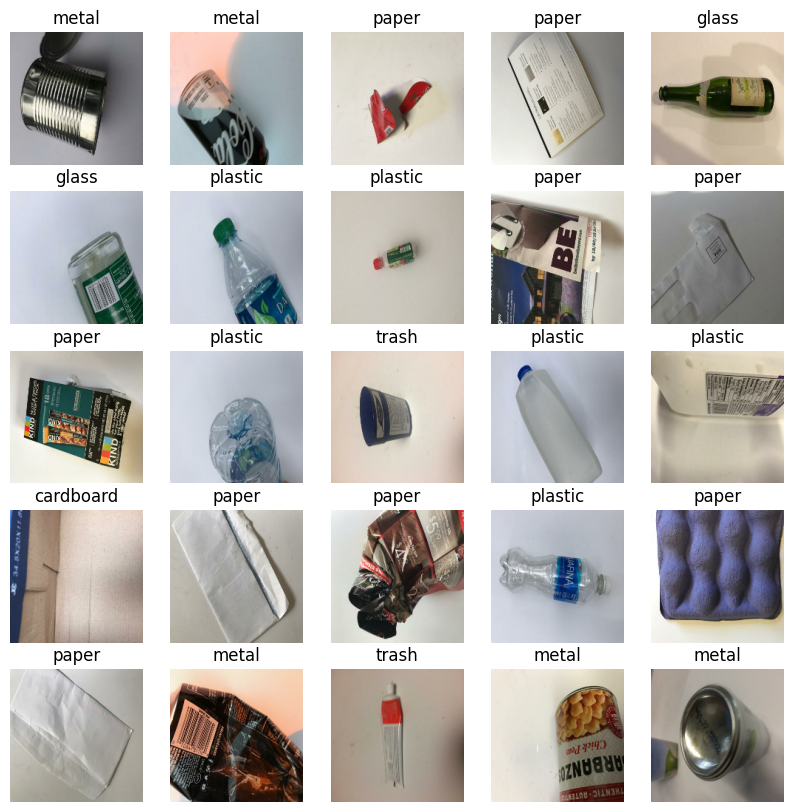

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(32, 180, 180, 3)
(32,)


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [33]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99252206


In [ ]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

c:\Users\jiray\OneDrive\Documents\Linear_project\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.keras',                  #เรียกกลับเมื่อค่า val_acc ลดลง
                                               monitor='val_accuracy', mode='max',
                                               verbose=1,)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) 

In [38]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=[callback, early_stopping]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2830 - loss: 1.8769
Epoch 1: saving model to best_model2.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.3497 - loss: 1.6188 - val_accuracy: 0.4693 - val_loss: 1.3390
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4626 - loss: 1.3180
Epoch 2: saving model to best_model2.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.4911 - loss: 1.2772 - val_accuracy: 0.5307 - val_loss: 1.1788
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6137 - loss: 1.0494
Epoch 3: saving model to best_model2.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6073 - loss: 1.0412 - val_accuracy: 0.6812 - val_loss: 0.8599
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6956 - loss: 0.8504
Epoch 4: saving model to best_model2.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6904 - loss: 0.8444 - val_accuracy: 0.7663 - val_loss: 0.7051
Epoch 5/50
64/64 ━━